In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt

In [2]:
split_kwargs = dict(
    n=30, 
    window_len=365 * 2, 
    set_lens=(180,), 
    left_to_right=False
)  # 30 windows, each 2 years long, reserve 180 days for test
portfolio_kwargs = dict(
    direction='all',  # long and short
    freq='d'
)
windows = np.arange(10, 50)

In [3]:
price = vbt.YFData.download('BTC-USD').get('Close')

In [4]:
print(price)

Date
2014-09-17 00:00:00+00:00      457.334015
2014-09-18 00:00:00+00:00      424.440002
2014-09-19 00:00:00+00:00      394.795990
2014-09-20 00:00:00+00:00      408.903992
2014-09-21 00:00:00+00:00      398.821014
                                 ...     
2021-04-28 00:00:00+00:00    54824.703125
2021-04-29 00:00:00+00:00    53555.109375
2021-04-30 00:00:00+00:00    57750.175781
2021-05-01 00:00:00+00:00    57828.050781
2021-05-02 00:00:00+00:00    56573.363281
Name: Close, Length: 2416, dtype: float64


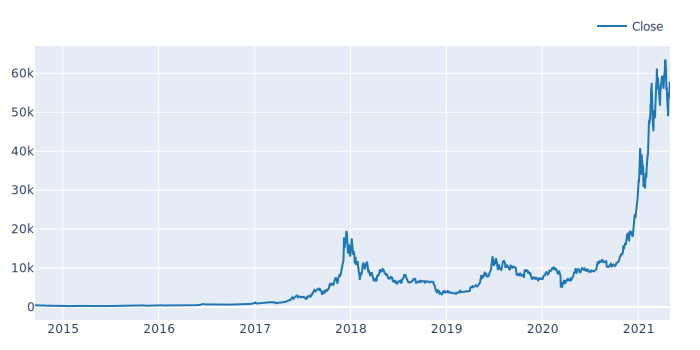

In [4]:
price.vbt.plot().show_svg()

In [5]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

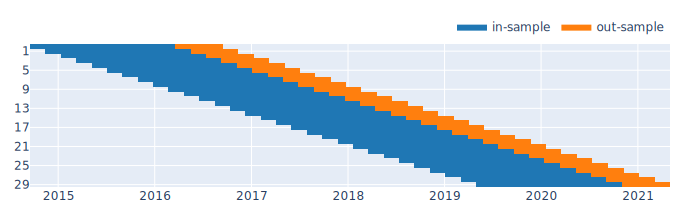

In [6]:
roll_in_and_out_samples(price, **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample']).show_svg()

In [7]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(price, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample

(550, 30) 30
(180, 30) 30


In [8]:
def simulate_holding(price, **kwargs):
    portfolio = vbt.Portfolio.from_holding(price, **kwargs)
    return portfolio.sharpe_ratio()

In [9]:
in_hold_sharpe = simulate_holding(in_price, **portfolio_kwargs)

print(in_hold_sharpe)

split_idx
0     0.229171
1     0.459087
2     1.258132
3     1.193770
4     1.591677
5     2.048547
6     2.378042
7     1.958393
8     2.363681
9     2.699550
10    2.801100
11    3.052888
12    2.609271
13    2.269722
14    2.005899
15    1.746719
16    1.727573
17    0.846535
18    0.618767
19    0.456840
20    0.476029
21    0.155296
22    0.511084
23    0.358838
24    0.597015
25    0.557476
26    0.656786
27    1.168030
28    1.259822
29    1.248517
Name: sharpe_ratio, dtype: float64


In [10]:
def simulate_all_params(price, windows, **kwargs):
    fast_ma, slow_ma = vbt.MA.run_combs(price, windows, r=2, short_names=['fast', 'slow'])
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    portfolio = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return portfolio.sharpe_ratio()

In [11]:
# Simulate all params for in-sample ranges
in_sharpe = simulate_all_params(in_price, windows, **portfolio_kwargs)

print(in_sharpe)

fast_window  slow_window  split_idx
10           11           0            0.856870
                          1            1.097501
                          2            0.376684
                          3            0.455088
                          4            0.639666
                                         ...   
48           49           25           1.830233
                          26          -0.041031
                          27           0.068637
                          28          -0.512800
                          29          -1.169421
Name: sharpe_ratio, Length: 23400, dtype: float64


In [12]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split_idx').idxmax()].index
    return performance[performance.groupby('split_idx').idxmin()].index

In [13]:
in_best_index = get_best_index(in_sharpe)

print(in_best_index)

MultiIndex([(27, 29,  0),
            (27, 29,  1),
            (21, 25,  2),
            (23, 25,  3),
            (20, 41,  4),
            (20, 41,  5),
            (41, 42,  6),
            (37, 43,  7),
            (37, 43,  8),
            (10, 21,  9),
            (10, 21, 10),
            (10, 21, 11),
            (10, 21, 12),
            (10, 21, 13),
            (10, 21, 14),
            (10, 21, 15),
            (10, 22, 16),
            (10, 22, 17),
            (10, 22, 18),
            (17, 22, 19),
            (17, 22, 20),
            (13, 21, 21),
            (45, 48, 22),
            (45, 49, 23),
            (45, 49, 24),
            (18, 21, 25),
            (13, 21, 26),
            (13, 20, 27),
            (13, 20, 28),
            (13, 20, 29)],
           names=['fast_window', 'slow_window', 'split_idx'])


In [14]:
def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

In [15]:
in_best_fast_windows = get_best_params(in_best_index, 'fast_window')
in_best_slow_windows = get_best_params(in_best_index, 'slow_window')
in_best_window_pairs = np.array(list(zip(in_best_fast_windows, in_best_slow_windows)))

print(in_best_window_pairs)

[[27 29]
 [27 29]
 [21 25]
 [23 25]
 [20 41]
 [20 41]
 [41 42]
 [37 43]
 [37 43]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 22]
 [10 22]
 [10 22]
 [17 22]
 [17 22]
 [13 21]
 [45 48]
 [45 49]
 [45 49]
 [18 21]
 [13 21]
 [13 20]
 [13 20]
 [13 20]]


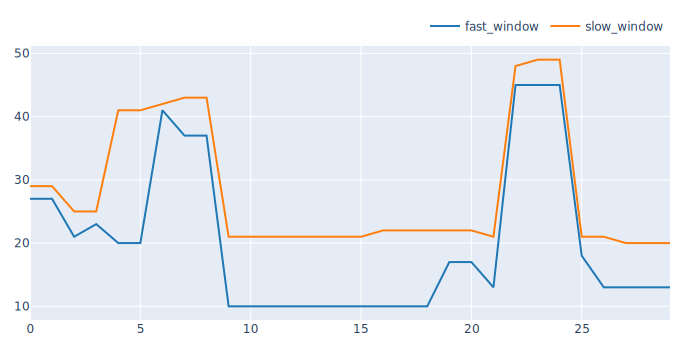

In [16]:
pd.DataFrame(in_best_window_pairs, columns=['fast_window', 'slow_window']).vbt.plot().show_svg()

In [17]:
out_hold_sharpe = simulate_holding(out_price, **portfolio_kwargs)

print(out_hold_sharpe)

split_idx
0     1.773721
1     1.958499
2     1.686644
3     2.684462
4     2.928572
5     3.003108
6     3.497229
7     3.494311
8     3.687199
9     2.216706
10    1.135060
11   -1.367843
12   -1.006925
13   -0.715992
14   -1.789592
15   -1.801691
16   -0.536478
17    2.768972
18    3.018891
19    2.199552
20   -0.124947
21   -0.140312
22   -1.218439
23    0.677830
24    0.592734
25    2.468891
26    2.636862
27    5.143888
28    4.538139
29    3.899192
Name: sharpe_ratio, dtype: float64


In [18]:
# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, windows, **portfolio_kwargs)

print(out_sharpe)

fast_window  slow_window  split_idx
10           11           0           -1.018512
                          1           -0.973724
                          2            1.646358
                          3            0.337991
                          4            1.862280
                                         ...   
48           49           25          -1.029267
                          26          -2.132047
                          27           2.709654
                          28           4.142129
                          29           2.492854
Name: sharpe_ratio, Length: 23400, dtype: float64


In [19]:
def simulate_best_params(price, best_fast_windows, best_slow_windows, **kwargs):
    fast_ma = vbt.MA.run(price, window=best_fast_windows, per_column=True)
    slow_ma = vbt.MA.run(price, window=best_slow_windows, per_column=True)
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    portfolio = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return portfolio.sharpe_ratio()

In [20]:
# Use best params from in-sample ranges and simulate them for out-sample ranges
out_test_sharpe = simulate_best_params(out_price, in_best_fast_windows, in_best_slow_windows, **portfolio_kwargs)

print(out_test_sharpe)

ma_window  ma_window  split_idx
27         29         0            1.164082
                      1            0.290499
21         25         2            1.779768
23         25         3            1.543974
20         41         4            0.114459
                      5            1.963370
41         42         6            0.750199
37         43         7           -1.622210
                      8            1.806276
10         21         9            2.680307
                      10           2.611956
                      11           1.426841
                      12           2.091782
                      13           0.448921
                      14           0.720844
                      15          -0.148826
           22         16           1.741600
                      17           2.829548
                      18           1.459040
17         22         19           0.621850
                      20           0.053594
13         21         21           1.091201


In [21]:
cv_results_df = pd.DataFrame({
    'in_sample_hold': in_hold_sharpe.values,
    'in_sample_median': in_sharpe.groupby('split_idx').median().values,
    'in_sample_best': in_sharpe[in_best_index].values,
    'out_sample_hold': out_hold_sharpe.values,
    'out_sample_median': out_sharpe.groupby('split_idx').median().values,
    'out_sample_test': out_test_sharpe.values
})

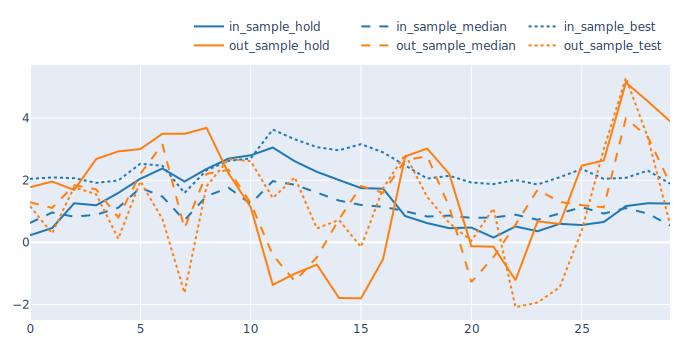

In [22]:
cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=vbt.settings.color_schema['blue']),
        dict(line_color=vbt.settings.color_schema['blue'], line_dash='dash'),
        dict(line_color=vbt.settings.color_schema['blue'], line_dash='dot'),
        dict(line_color=vbt.settings.color_schema['orange']),
        dict(line_color=vbt.settings.color_schema['orange'], line_dash='dash'),
        dict(line_color=vbt.settings.color_schema['orange'], line_dash='dot')
    ]
).show_svg()